In [1]:
#!/usr/bin/env python3
import tensorflow as tf

import os

import matplotlib.pyplot as plt 
import matplotlib
import matplotlib.gridspec as gridspec
import matplotlib.dates as mdates

import numpy as np
import pandas as pd

import json

from src.ForecastModel.data.models import DataModelCV
from src.ForecastModel.utils.postprocessing import ModelHandler

plt.rcParams.update({
    "text.usetex": False,
    'font.size'   : 6,
})

In [2]:
PLOT_PATH          = r"hess_paper_output"
DATA_PATH          = r"src\data\Dataset.csv"
CROSS_INDICES_PATH = r"src\data\indices"

In [3]:
model_handle =  ModelHandler("PBHM-HLSTM",
                           r"models\PBHM-HLSTM",
                           is_final_model = True,
                           color = "#e41a1c",
                           ls = "-",
                          )

## load model and data

In [4]:
# initalize
m  = 200 # number of lamellas to approximate integral, m=200 for results - m=1 for testing
num_hindcast_feat = len(model_handle.feat_hindcast)
num_forecast_feat = len(model_handle.feat_forecast)


# load datamodel
dm = DataModelCV(DATA_PATH,
       target_name       = model_handle.target_name,
       hincast_features  = model_handle.feat_hindcast,
       forecast_features = model_handle.feat_forecast,
     )

# load trial data
with open(os.path.join(model_handle.hp_path, "trial.json")) as f:
    trial = json.load(f)
   
hindcast_length = trial['hyperparameters']['values']['hindcast_length'] 
forecast_length = 96

dm.main(os.path.join(CROSS_INDICES_PATH, f"cross_indices_{hindcast_length}.pkl"))


dfs = {}
all_intgrad_0 = np.zeros((5, forecast_length, num_hindcast_feat, 2))
all_intgrad_1 = np.zeros((5, forecast_length, num_forecast_feat, 2))


# load model of fold 5 (final model)
tf.keras.backend.clear_session()
keras_save_file_path = os.path.join(model_handle.hp_path, f"model_fold_{4:d}.keras")
model  = tf.keras.models.load_model(keras_save_file_path)

for n_fold in range(5):
    print(f"processing fold {n_fold}")
    
    # load dataset
    X, y  = dm.getDataSet(dm.cross_sets[n_fold]["test"], scale=True) 

    # get baseline input
    X_base = tf.zeros_like(X[0])

    # find indcies of 2 most prominent flood events
    idx_1  = np.argmax(np.max(y, axis=1), axis=0)[0]
    y2 = y.copy()
    y2[idx_1-2*96:idx_1+2*96] = 0
    idx_2  = np.argmax(np.max(y2, axis=1), axis=0)[0]
    
    peak_indices = [idx_1, idx_2]

    df = pd.DataFrame()
    for n, idx in enumerate(peak_indices):
        print(f"{n+1} / {2}", end="\r")
        
        X_tensor_0 = tf.convert_to_tensor(X[0][idx:idx+forecast_length,:,:], dtype=tf.float32)
        X_tensor_1 = tf.convert_to_tensor(X[1][idx:idx+forecast_length,:,:], dtype=tf.float32)
        
        base_tensor_0 = tf.zeros_like(X_tensor_0)
        base_tensor_1 = tf.zeros_like(X_tensor_1)
        
        offset_tensor_0 = (X_tensor_0 - base_tensor_0) / tf.constant(m, dtype=tf.float32)
        offset_tensor_1 = (X_tensor_1 - base_tensor_1) / tf.constant(m, dtype=tf.float32)
        
        for k in range(1, m+1):
            inp_tensor_0 = X_tensor_0 + tf.constant(k, dtype=tf.float32) * offset_tensor_0
            inp_tensor_1 = X_tensor_1 + tf.constant(k, dtype=tf.float32) * offset_tensor_1
            inp_tensor_list = [inp_tensor_0 , inp_tensor_1]
        
            with tf.GradientTape() as t:
                t.watch(inp_tensor_0)
                t.watch(inp_tensor_1)
                output = tf.math.reduce_max(model(inp_tensor_list), axis=1) # analysis at model output peak 
                #output = model(inp_tensor_list)[:, offset] # analysis at flood event peak 
    
            grad_0, grad_1 = t.gradient(output, inp_tensor_list)
            
            if k == 1:
                total_grad_0 = grad_0
                total_grad_1 = grad_1
            else:
                total_grad_0 += grad_0
                total_grad_1 += grad_1

        # integrated gradients of size (forecast_length, num_of_nodes, num_of_features)
        integrated_grad_0 = offset_tensor_0 * total_grad_0
        integrated_grad_1 = offset_tensor_1 * total_grad_1
        
        # sumed over peak positions in the forecast window and over the forecast/hindcast input nodes 
        df.loc[n, ["h_" + x for x in model_handle.feat_hindcast]] = np.sum(np.sum(np.abs(integrated_grad_0), axis=0)/hindcast_length,axis=0)
        df.loc[n, ["f_" + x for x in model_handle.feat_forecast]] = np.sum(np.sum(np.abs(integrated_grad_1), axis=0)/forecast_length, axis=0)
    
        # absolute average over forecast/hindcast input nodes 
        all_intgrad_0[n_fold, :, :, n] = np.sum(np.abs(integrated_grad_0), axis=1) / hindcast_length
        all_intgrad_1[n_fold, :, :, n] = np.sum(np.abs(integrated_grad_1), axis=1) / forecast_length

        dfs[f"fold-{n_fold}"] = df.copy()
df = pd.concat(dfs)

# save results
df.to_pickle(os.path.join(model_handle.hp_path, "ig_peaks.pkl"))

print("  done  ")

dictonary loaded
processing fold 0
processing fold 1
processing fold 2
processing fold 3
processing fold 4
  done  


In [5]:
# load results
df = pd.read_pickle(os.path.join(model_handle.hp_path, "ig_peaks.pkl"))

## summary of hindcast features - 2 major peaks for all folds

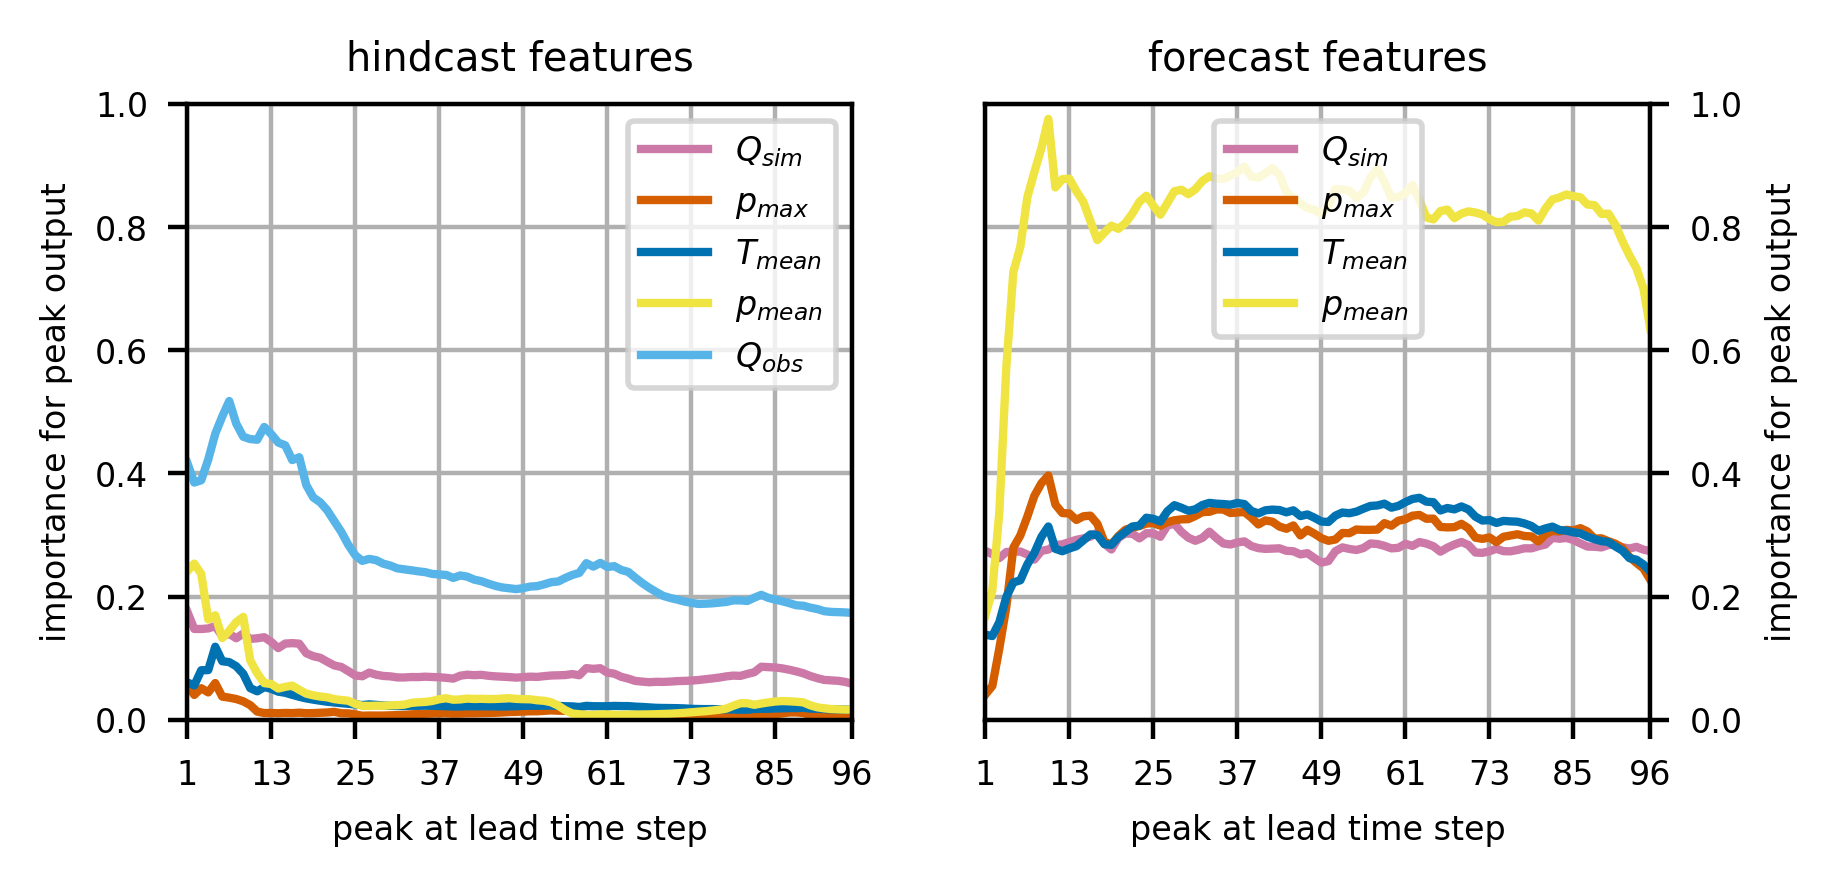

In [6]:
colors = ["#CC79A7", "#D55E00", "#0072B2", "#F0E442", "#56B4E9"]
feat_names = [r"$Q_{sim}$", r"$p_{max}$", r"$T_{mean}$", r"$p_{mean}$", r"$Q_{obs}$"]

fig,axes = plt.subplots(1, 2, figsize=(4.72,2), dpi=400)


for n in range(all_intgrad_0.shape[2]):
    # sum over peaks and over folds
    axes[0].plot(np.sum(np.sum(all_intgrad_0[:,:,n,:], axis=2), axis=0), c=colors[n], label=feat_names[n])
    
axes[0].set_title("hindcast features")
axes[0].set_xlabel("peak at lead time step")
axes[0].set_ylabel("importance for peak output")
axes[0].set_xticks([0] + [x for x in range(11,98,12)])
axes[0].set_xticklabels([f"{int(95-x)+1:d}" for x in axes[0].get_xticks()])
axes[0].set_xlim([95,0])
axes[0].set_ylim([0,1])
axes[0].legend()
axes[0].grid()


for n in range(all_intgrad_1.shape[2]):
    # sum over all peaks and over all folds
    axes[1].plot(np.sum(np.sum(all_intgrad_1[:,:,n,:], axis=2), axis=0), c=colors[n], label=feat_names[n])
    
axes[1].yaxis.set_label_position("right")
axes[1].yaxis.tick_right()
axes[1].set_title("forecast features")
axes[1].set_xlabel("peak at lead time step")
axes[1].set_ylabel("importance for peak output")
axes[1].set_xticks([0] + [x for x in range(11,98,12)])
axes[1].set_xticklabels([f"{int(95-x)+1:d}" for x in axes[1].get_xticks()])
axes[1].set_xlim([95,0])
axes[1].set_ylim([0,1])
axes[1].legend(loc="upper center")
axes[1].grid()


In [7]:
# save figure
fig.savefig(os.path.join(PLOT_PATH, "fig9-ig_2-peaks-all_folds.png"), bbox_inches="tight")

In [8]:
df

h_qsim    h_pmax   h_tmean   h_pmean  h_qmeasval    f_qsim  \
fold-0 0  0.197619  0.034366  0.192035  0.177857    1.092474  0.482908   
       1  2.149094  0.133005  0.278261  0.739403    3.434914  4.887031   
fold-1 0  1.144678  0.056986  0.394479  0.346886    5.943955  4.008034   
       1  1.088036  0.166258  0.259980  0.897294    3.179551  3.820770   
fold-2 0  0.189786  0.147214  0.381429  0.420090    0.797321  0.730208   
       1  0.249131  0.051637  0.099060  0.103583    1.639667  2.305002   
fold-3 0  0.665937  0.324309  0.478523  0.484662    4.750619  3.436767   
       1  1.954881  0.120557  0.228668  0.450641    3.505902  4.083043   
fold-4 0  0.360632  0.059293  0.263979  0.224294    0.903536  2.678572   
       1  0.098183  0.094728  0.241358  0.169863    0.352120  0.747304   

            f_pmax   f_tmean    f_pmean  
fold-0 0  1.376487  1.377307   7.239651  
       1  0.275881  2.047868   3.293639  
fold-1 0  0.362949  1.932351   4.198126  
       1  0.896380  2.383995   3.362413  
fold-2 0  1.860882  2.744665   7.963608  
       1  1.550865  3.167651   5.340260  
fold-3 0  6.075224  4.824832  12.036308  
       1  0.314732  1.670282   4.417826  
fold-4 0  9.865141  5.737325  16.063156  
       1  6.525916  4.000547  14.428855